# Data

> Data handling functions


In [7]:
#| default_exp data

In [8]:
#| hide
from nbdev.showdoc import *

#### Import libraries

In [4]:
#| export

import argparse
import os
import h5py
import cv2
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

## Get Dataset


In [10]:
#| export

def get_FMD_img_paths(base_path):
    file_paths = list()
    for full_path, _, file_names in os.walk(os.path.join(base_path, 'raw')):
        for file_name in file_names:
            if 'png' in file_name:
                raw_path = os.path.join(full_path, file_name)
                gt_path = os.path.join(full_path.replace('raw','gt'), 'avg50.png')
                if os.path.exists(gt_path):
                    file_paths.append({'GT':gt_path,'NOISY': raw_path})
    return file_paths


In [11]:
len(get_FMD_img_paths('../_data/Confocal_BPAE_B'))

1000

## Metadata

In [19]:
#| export

def convert_setup_code(model_name):
    models = ['100x', '060x']
    for idx, model in enumerate(models):
        if model == model_name: return idx
    assert False, "Invalid setup code."


TO DO: add code similar to next cell that can read info from metadata

In [16]:
#| export

def parse_dir_name(dir_name):
    tokens = dir_name.split('_')
    return {
        'scene-instance-number': int(tokens[0]),
        'scene-number': int('001'),
        'setup-code': int(convert_setup_code('060x')),
        'pixel-size': int('0100'), # nm
        'exposure-time': int('00060'), # ms
        'wavelength': int('600'), # nm
        'photon-flux':int('0100') # photons/nm/ms
    }

## Transforms

### Crop

Crop whole image into patches

In [14]:
#| export

def crop(img, size, overlap):
    crops = list()
    img = img.transpose(2,0,1)
    _,h,w = img.shape
    i,j = 0, 0
    while i < h:
        while j < w:
            roi_x, roi_y = j, i
            if i + size > h: roi_y = h - size 
            if j + size > w: roi_x = w - size
            # crops.append(img[:,roi_y:roi_y+size,roi_x:roi_x+size])
            crops.append(img[:1,roi_y:roi_y+size,roi_x:roi_x+size])
            j+=overlap
        j=0
        i+=overlap
    i=0
    return crops

In [15]:
#| export



## Preprocessing

In [16]:
#| export

def preprocessing(data_path='../_data/Confocal_BPAE_B',
                    patch_size = 96,
                    overlap = 8,
                    mode = 'NOISE_GEN', # ['NOISE_GEN', 'DENOISER', 'ALL']
                    output_base_path = '../_data/HDF5_confocal_s96_o08',
                    ):
    
    TRAIN_NOISEGEN_INDICES = [1] #[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
    TRAIN_DENOISER_INDICES = TRAIN_NOISEGEN_INDICES
    TRAIN_ALL_INDICES = TRAIN_NOISEGEN_INDICES
    TEST_INDICES = [19, 20]

    img_paths = get_FMD_img_paths(data_path) #load paths
    
    for img_idx, img_path in enumerate(tqdm(img_paths)):
        img_gt = cv2.imread(img_path['GT'], cv2.IMREAD_COLOR) # read gt images
        img_noisy = cv2.imread(img_path['NOISY'], cv2.IMREAD_COLOR) # read noisy images
        config = parse_dir_name(img_path['GT'].split('/')[-2])
        
        img_gt_crops = crop(img_gt, patch_size, overlap)
        img_noisy_crops = crop(img_noisy, patch_size, overlap)
        assert len(img_gt_crops) == len(img_noisy_crops)

        output_dir_path  = output_base_path
        if mode == 'NOISE_GEN':
            if config['scene-instance-number'] in TRAIN_NOISEGEN_INDICES:
                output_dir_path += '/noise_gen/train/'
            elif config['scene-instance-number'] in TEST_INDICES:
                output_dir_path += '/noise_gen/test/'
            else:
                continue
        elif mode == 'DENOISER':
            if config['scene-instance-number'] in TRAIN_DENOISER_INDICES:
                output_dir_path += '/denoiser/'
            else:
                continue
        elif mode == 'ALL':
            if config['scene-instance-number'] in TRAIN_ALL_INDICES:
                output_dir_path += '/all/'
            else:
                continue
            
        os.makedirs(output_dir_path, exist_ok=True)
        output_file_name = '%04d_%s.hdf5'%(img_idx, img_path['GT'].split('/')[-2])
        hdf_file_path = os.path.join(output_dir_path, output_file_name)
        with h5py.File(hdf_file_path, "w") as f:
            for patch_idx, (gt, noisy) in enumerate(zip(img_gt_crops, img_noisy_crops)):
                f.create_dataset(f'clean/{patch_idx}', data=gt)
                f.create_dataset(f'noisy/{patch_idx}', data=noisy)
            hdf5_config = f.create_group('config')
            for key in config:
                hdf5_config.attrs[key] = config[key]

In [17]:
preprocessing()

100%|██████████| 1000/1000 [01:45<00:00,  9.48it/s]


In [ ]:
#| export



In [ ]:
#| export



In [ ]:
#| export



## Preprocessing Utils

In [18]:
#| export

def find_support_scene(img_paths, current_path):
    random.shuffle(img_paths) # shuffling
    current_config = parse_dir_name(current_path['GT'].split('/')[-2])
    for img_path in img_paths:
        target_config = parse_dir_name(img_path['GT'].split('/')[-2])
        if target_config['setup-code'] == current_config['setup-code'] and \
        target_config['pixel-size'] == current_config['pixel-size'] and \
        target_config['scene-instance-number'] != current_config['scene-instance-number']:
            return img_path
    assert False, "There is no matching scene."

In [2]:
#| export

def load_and_display_hdf5_image(file_path, dataset_name='clean'):
    with h5py.File(file_path, 'r') as file:
        image_data = file[dataset_name + '/20'][:] 
        print(image_data.shape)
    plt.imshow(image_data[0], cmap='gray')  # Adjust cmap as per your image format
    plt.axis('off')
    plt.show()



../_data/HDF5_confocal_s96_o08/noise_gen/test/0100_20.hdf5
(1, 96, 96)


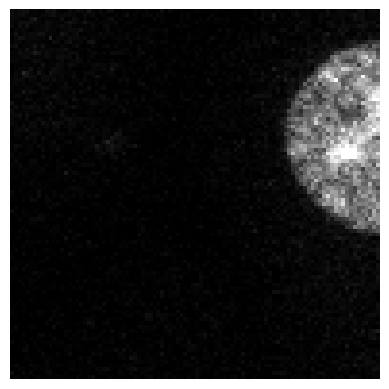

In [5]:
# Example usage:
output_base_path = '../_data/HDF5_confocal_s96_o08'
file_path = output_base_path + '/noise_gen/test/0100_20.hdf5'
print(file_path)
load_and_display_hdf5_image(file_path, dataset_name='noisy')

In [22]:
#| hide
import nbdev; nbdev.nbdev_export()